# Movies Recommender 🍿 - Building a Recommendation System
A project proposal by **Adi Benziony (ID 313364549)**

## Introduction and Motivation
The film industry is a giant business, and every year thousands of new movies are made. In 2019 alone 4,693 new movies were released ([source](https://www.the-numbers.com/movies/production-countries#tab=year)).  
With all those new movies released each year it can be confusing to choose which movies to see, and that's where a personalized recommendation system can come in handy.

The growth in digital data volume that's at the disposal of big companies allowed a new era of personalized recommendation systems to arise.  
Every company serving consumers content wants to find a way to keep the consumer engaged and entertained, one of the ways this can be achived is by making it easier for the user to find content he will like.  
Companies like Spotify, Netflix, Twitter, Facebook and even dating apps such as Tinder all have recommendation systems to keep users on the platform.

![Netflix recommendations](https://github.com/adi-benz/movies-rating-analysis/raw/main/resources/recommendations-banner.png)

In this notebook we will use [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) posted on Kaggle to build **a recommendation system for movies based on a user's ratings**.

## Dataset
This project is inspired by the dataset [The Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) posted on Kaggle, featuring movies information like title, genres, release date and more along with users' movies ratings.  
The dataset is a combination of [_MovieLens_](https://movielens.org/) and [_TMDB_](https://www.themoviedb.org/).  
MovieLens is a research site run by _GroupLens Research_ at the University of Minnesota and contains users' movies ratings, and _TMDB_ is a website containing data on millions of movies.

Our dataset cotains:
* **45,000 movies** in various languages (but mostly English) with properties like budget, revenue, genres, language, release date, duration, and ratings.
* **26 million ratings by 260,000 users**

## Dataset Loading & Cleanup
We will start by loading `movies-dataset/movies_metadata.csv`.  
Note, the original CSV uploaded to Kaggle had some lines with unescaped newlines in their movie description fields, the CSV in the project's Git repository is a fixed version of the CSV from Kaggle.

Let's load the dataset and start inspecting it:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
movies_metadata = pd.read_csv('movies-dataset/movies_metadata.csv')
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45463 entries, 0 to 45462
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45463 non-null  bool   
 1   belongs_to_collection  4491 non-null   object 
 2   budget                 45463 non-null  int64  
 3   genres                 45463 non-null  object 
 4   homepage               7779 non-null   object 
 5   id                     45463 non-null  int64  
 6   imdb_id                45446 non-null  object 
 7   original_language      45452 non-null  object 
 8   original_title         45463 non-null  object 
 9   overview               44509 non-null  object 
 10  popularity             45463 non-null  float64
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

We can see that the `release_date` field is not of type `datetime`, so let's change that:

In [3]:
movies_metadata = pd.read_csv('movies-dataset/movies_metadata.csv', parse_dates=['release_date'])

Let's also load the `credits.csv` and `keywords.csv` files

In [4]:
credits = pd.read_csv('movies-dataset/credits.csv')

In [5]:
keywords = pd.read_csv('movies-dataset/keywords.csv')
keywords_dups_count = keywords[keywords.duplicated()].shape[0]
keywords = keywords[~keywords.duplicated()]

print(f'Removed {keywords_dups_count} duplicated rows from `keywords`')

Removed 987 duplicated rows from `keywords`


# Data Exploration

Now for some exploration, let's look at some rows of our datasets:

In [6]:
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173


In [7]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


The credits dataset is made up of `cast` and `crew`, this is their structure:

In [8]:
toy_story_crew_df = pd.DataFrame(data=eval(credits['crew'][0]))
toy_story_crew_df

,credit_id,department,gender,id,job,name,profile_path
0,52fe4284c3a36847f8024f49,Directing,2,7879,Director,John Lasseter,/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg
1,52fe4284c3a36847f8024f4f,Writing,2,12891,Screenplay,Joss Whedon,/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg
2,52fe4284c3a36847f8024f55,Writing,2,7,Screenplay,Andrew Stanton,/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg
3,52fe4284c3a36847f8024f5b,Writing,2,12892,Screenplay,Joel Cohen,/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg
4,52fe4284c3a36847f8024f61,Writing,0,12893,Screenplay,Alec Sokolow,/v79vlRYi94BZUQnkkyznbGUZLjT.jpg
...,...,...,...,...,...,...,...
101,589216c19251412dc2009cb9,Sound,1,1748724,Assistant Sound Editor,Susan Sanford,None
102,589216ccc3a3680973009274,Sound,0,1748725,Assistant Sound Editor,Susan Popovic,None
103,589216d79251412dc8009aa0,Sound,0,8067,Assistant Sound Editor,Dan Engstrom,None
104,589216e49251412dcd009a4f,Production,1,7902,Casting Consultant,Ruth Lambert,None


In [9]:
toy_story_crew_df["job"].value_counts().sort_values().to_frame()

,job
Sound Effects Editor,1
Editorial Coordinator,1
Casting Consultant,1
Editorial Manager,1
Director,1
Songs,1
Visual Effects Supervisor,1
Executive Music Producer,1
Production Supervisor,1
Sound Design Assistant,1


In [10]:
pd.DataFrame(data=eval(credits['cast'][0]))

,cast_id,character,credit_id,gender,id,name,order,profile_path
0,14,Woody (voice),52fe4284c3a36847f8024f95,2,31,Tom Hanks,0,/pQFoyx7rp09CJTAb932F2g8Nlho.jpg
1,15,Buzz Lightyear (voice),52fe4284c3a36847f8024f99,2,12898,Tim Allen,1,/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg
2,16,Mr. Potato Head (voice),52fe4284c3a36847f8024f9d,2,7167,Don Rickles,2,/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg
3,17,Slinky Dog (voice),52fe4284c3a36847f8024fa1,2,12899,Jim Varney,3,/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg
4,18,Rex (voice),52fe4284c3a36847f8024fa5,2,12900,Wallace Shawn,4,/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg
5,19,Hamm (voice),52fe4284c3a36847f8024fa9,2,7907,John Ratzenberger,5,/yGechiKWL6TJDfVE2KPSJYqdMsY.jpg
6,20,Bo Peep (voice),52fe4284c3a36847f8024fad,1,8873,Annie Potts,6,/eryXT84RL41jHSJcMy4kS3u9y6w.jpg
7,26,Andy (voice),52fe4284c3a36847f8024fc1,0,1116442,John Morris,7,/vYGyvK4LzeaUCoNSHtsuqJUY15M.jpg
8,22,Sid (voice),52fe4284c3a36847f8024fb1,2,12901,Erik von Detten,8,/twnF1ZaJ1FUNUuo6xLXwcxjayBE.jpg
9,23,Mrs. Davis (voice),52fe4284c3a36847f8024fb5,1,12133,Laurie Metcalf,9,/unMMIT60eoBM2sN2nyR7EZ2BvvD.jpg


In [11]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


We can merge the 3 datasets into one, this will make it easier as we progress

In [12]:
movies = movies_metadata.merge(credits, on='id').merge(keywords, on='id')

We need to know who our recommendation system will cater to, this will depend on how much our dataset is skwed.  
So let's look at some basic statistics of language, budget, revenu, release dates, duration, votes count and genres.

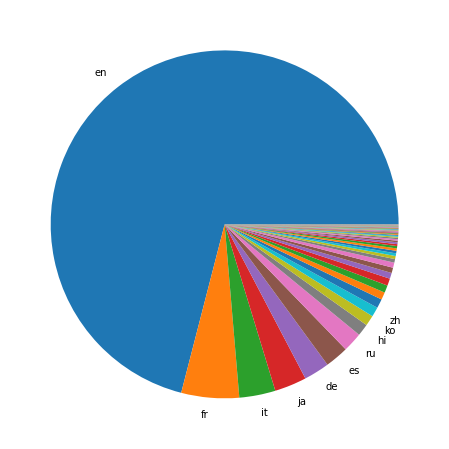

In [13]:
lng_counts = movies['original_language'].value_counts()

top_lng = lng_counts.index.tolist()[:10]
labels = top_lng + [""]*(lng_counts.index.size - 10)
plt.figure(figsize=(8, 8))
plt.pie(lng_counts, labels=labels)

plt.show()

English is the most dominent language in our dataset, while there's also French, Italian, Japanease, German, Spanish, Russian and more.

Let's look at statistics about the release dates and the duration:  

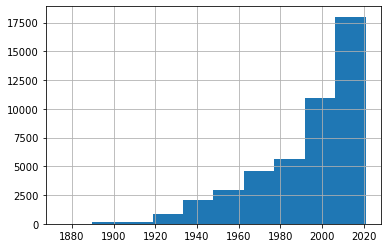

In [14]:
movies['release_date'].hist()
plt.show()

We can see that our dataset is comprised mainly from movies made in recent years, this doesn't necessarily mean that our data is skwed, maybe there really were more movies made in recent years than before.

In [15]:
movies[movies["runtime"] > 400][["title", "runtime", "overview", "keywords", "genres", "original_language", "imdb_id"]].shape

(50, 7)

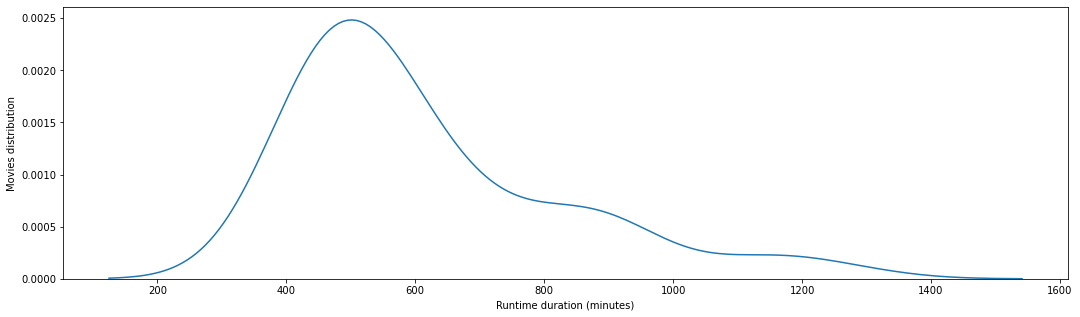

In [16]:
plt.figure(figsize=(18,5))
plt.xlabel("Runtime duration (minutes)")
plt.ylabel("Movies distribution")

# To make the plot more readable we'll remove movies with runtime of over 400 minutes (there's only 25 of them)
sns.kdeplot(data=movies[movies["runtime"] > 400], x="runtime")

plt.show()

The average duration is a little more than an hour and a half, and most movies are between an hour and 2 hours.

Next, let's take a look at the different genres.  
In order to do that we will need to make the genres data usable. Currently the genres of each movie is stored as follows:

In [17]:
movies[movies['title'] == 'Toy Story'][['title', 'genres']]

,title,genres
0,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."


We'll convert the `genres` field to a simple list of values, and we'll do the same for `keywords`.

For `crew` we will only save the director and for `cast` we will take the top 5 actors - which will be useful when building recommendations models.

In [18]:
movies["genres"] = movies["genres"].apply(lambda value: [x["name"] for x in eval(value)])
movies["keywords"] = movies["keywords"].apply(lambda value: [x["name"] for x in eval(value)])

In [19]:
def get_top_5_actors_names(cast):
    top_actors = eval(cast)[:5]
    return [actor["name"] for actor in top_actors]

movies["top_actors"] = movies["cast"].apply(lambda cast: get_top_5_actors_names(cast))
movies.drop(columns=["cast"], inplace=True)

In [20]:
def get_director_name(crew):
    for crew_member in eval(crew):
        if crew_member["job"] == "Director":
            return crew_member["name"]
movies["director"] = movies["crew"].apply(lambda crew: get_director_name(crew))
movies.drop(columns=["crew"], inplace=True)

To make it simpler to plot different aspects of movies' geners, we'll create a new `DataFrame` that will have a duplicate of each movie per its genre:

In [21]:
movies_genres = movies.explode('genres').rename(columns={'genres': 'genre'})

For example, for the movie "Toy Story" the `movies_genres` `DataFrame` will store the genres as follows:

In [22]:
movies_genres[movies_genres['title'] == 'Toy Story'][['title', 'genre']]

,title,genre
0,Toy Story,Animation
0,Toy Story,Comedy
0,Toy Story,Family


We have the following genres:

In [23]:
genres = movies_genres.groupby("genre").size()\
                    .reset_index().rename(columns={0: 'count'})\
                    .sort_values('count', ascending=False).reset_index(drop=True)

genres

,genre,count
0,Drama,20312
1,Comedy,13196
2,Thriller,7640
3,Romance,6746
4,Action,6607
5,Horror,4679
6,Crime,4314
7,Documentary,3937
8,Adventure,3508
9,Science Fiction,3061


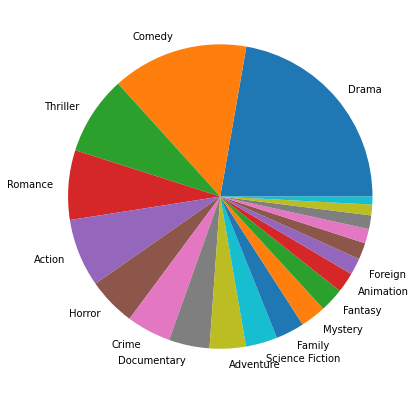

In [24]:
top_genres = genres["genre"].tolist()[:15]

genres_count = movies_genres['genre'].value_counts()
labels = top_genres + [""]*(genres_count.index.size - 15)
plt.figure(figsize=(7, 7))
a = plt.pie(genres_count, labels=labels)

It's clear that most movies produced are categorized as "Drama", "Comedy", "Thriller", "Romance", or "Action".

It will be interesting to see how different movie properties change based on genre. We'll keep it in mind going forward in this notebook.

Next, let's take a look at movies' votes

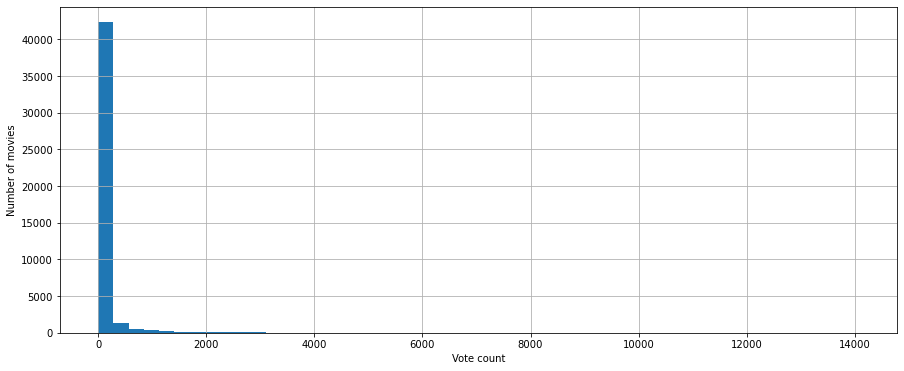

In [25]:
plt.figure(figsize=(15, 6))
movies['vote_count'].hist(bins=50)
plt.xlabel("Vote count")
plt.ylabel("Number of movies")
plt.show()

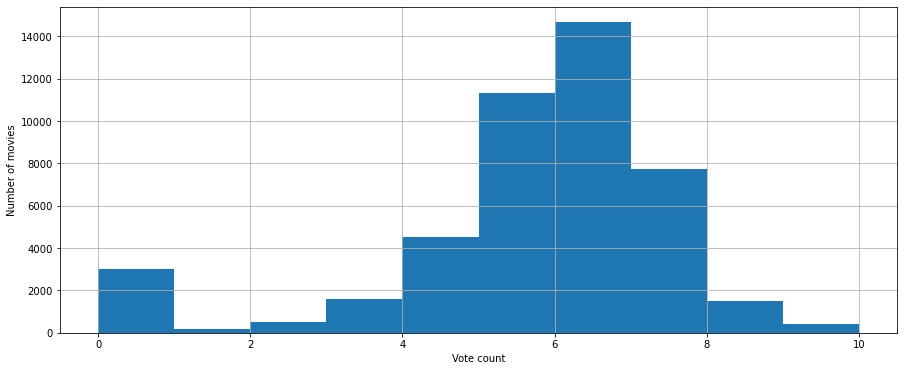

The average movie score is 5.6


In [26]:
plt.figure(figsize=(15, 6))
movies['vote_average'].hist()
plt.xlabel("Vote count")
plt.ylabel("Number of movies")
plt.show()

print(f'The average movie score is {movies["vote_average"].mean():.1f}')

We can deduce most movies have less than 500 ratings, and the average rating of a movie is 5.8

Next we will focus on the users ratings dataset from `movies-dataset/ratings.csv`

In [27]:
ratings = pd.read_csv('movies-dataset/ratings.csv').drop(columns=['timestamp'])
ratings.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [28]:
ratings.shape

(26024289, 3)

In [29]:
ratings.value_counts('userId').describe()

count    270896.000000
mean         96.067454
std         205.719606
min           1.000000
25%          15.000000
50%          30.000000
75%          93.000000
max       18276.000000
dtype: float64

We have 26,024,289 ratings from 270,896 users with an average number of movies rated by a user to be 96.

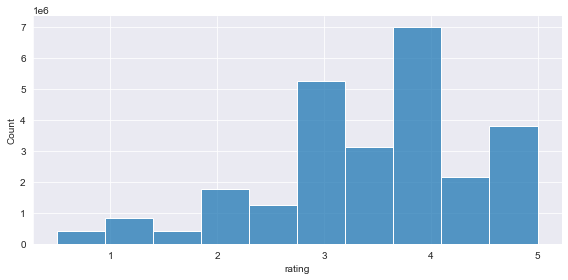

In [30]:
sns.set_style("darkgrid")
sns.displot(ratings, x="rating", bins=10, height=4, aspect=2)
plt.show()

Let's look at the most rated movies (by count) and the top rated movies (by score)

In [31]:
most_rated_movies = ratings.groupby('movieId').size()\
    .reset_index().rename(columns={0: 'count'})\
    .sort_values('count', ascending=False).reset_index(drop=True)
top_rated_movies = ratings.groupby('movieId').mean()\
    .drop(columns='userId').reset_index()\
    .sort_values('rating', ascending=False)\
    .reset_index(drop=True)
# m=movies.merge(links, left_on='id', right_on='tmdbId')

# movies = movies_metadata.merge(credits, on='id').merge(keywords, on='id')


Trying to merge the `movies` DataFrame with the `most_rated_movies` DataFrame shows a problem:

In [32]:
most_rated_movies.head(10).merge(movies, left_on='movieId', right_on='id')[["movieId", "title"]]

,movieId,title
0,318,The Million Dollar Hotel
1,296,Terminator 3: Rise of the Machines
2,593,Solaris
3,260,The 39 Steps
4,480,Monsoon Wedding
5,527,Once Were Warriors
6,110,Three Colors: Red


I don't recognize those movies, and seeing as those should be the movies with the most ratings this is unlikely.

Reading from the Kaggle project's description, I understand that the `id` column in `movies` DataFrame is probably the TMDB ID (the ID from the _The Movies Data Base_) where most info was scraped from and the `movieId` column in `ratings` is an ID from _MovieLens_ database, so let's fix that and make the `ratings` DataFrame have an `id` column like `movies`.

To do that we'll need another CSV that contains all the connections between the different IDs, the `links.csv` file

In [33]:
links = pd.read_csv('movies-dataset/links.csv').dropna().astype({"tmdbId": int})

In [34]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862


In [35]:
ratings = ratings.merge(links, on='movieId')[["userId", "tmdbId", "rating"]].rename(columns={"tmdbId": "movieId"})

Now, let's try to see the most rated movies' title

In [36]:
most_rated_movies = ratings.groupby('movieId').size()\
    .reset_index().rename(columns={0: 'count'})\
    .sort_values('count', ascending=False).reset_index(drop=True)
top_rated_movies = ratings.groupby('movieId').mean()\
    .drop(columns='userId').reset_index()\
    .sort_values('rating', ascending=False)\
    .reset_index(drop=True)

In [37]:
most_rated_movies.head(10).merge(movies, left_on='movieId', right_on='id')[["id", "title", "count"]]

,id,title,count
0,13,Forrest Gump,91921
1,278,The Shawshank Redemption,91082
2,680,Pulp Fiction,87901
3,274,The Silence of the Lambs,84078
4,603,The Matrix,77960
5,11,Star Wars,77045
6,329,Jurassic Park,74355
7,424,Schindler's List,67662
8,197,Braveheart,66512
9,862,Toy Story,66008


In [38]:
top_rated_movies.head(10).merge(movies, left_on='movieId', right_on='id')[["id", "title", "rating"]]

,id,title,rating
0,258113,Assepoester: Een Modern Sprookje,5.0
1,54583,Hollywood North,5.0
2,262831,Banana Paradise,5.0
3,262522,Poison,5.0
4,159550,The Last Brickmaker in America,5.0
5,69161,Heroes Shed No Tears,5.0
6,46121,The Capture of the Green River Killer,5.0
7,159763,A Nanny's Revenge,5.0
8,159898,The Boxing Cats (Prof. Welton's),5.0
9,159910,Hadj Cheriff,5.0


This list of movies makes more sense!

In [39]:
# TODO: Take more EDA ideas from https://www.kaggle.com/code/rounakbanik/the-story-of-film/notebook

## Description Words

For each movie we the `keywords` and the `overview` columns that contain actual text that can help us understand the movie better than just very general labels like `genres`.

In [40]:
keywords_count_by_movie = movies["keywords"].apply(lambda keywords: len(keywords)).sort_values().to_frame()

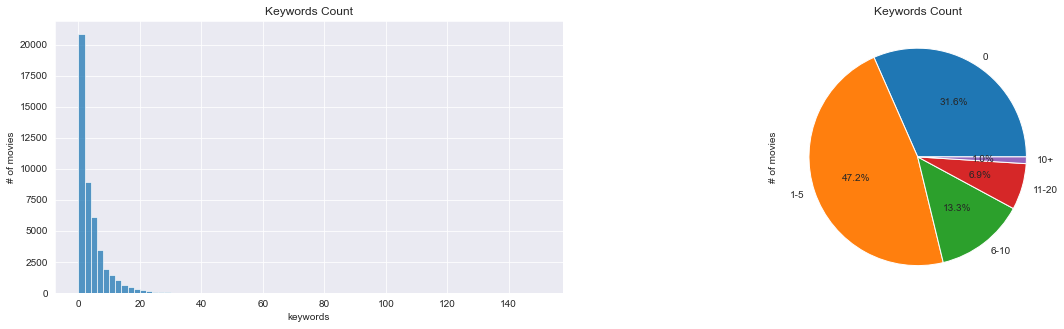

In [41]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(121)
sns.histplot(data=keywords_count_by_movie, x="keywords", binwidth=2, ax=ax1)
ax1.title.set_text("Keywords Count")
ax1.set_ylabel("# of movies")

ax2 = plt.subplot(122)
keywords_bins_cut = pd.cut(keywords_count_by_movie["keywords"], bins=[-1, 0, 5, 10, 20, 200], labels=["0", "1-5", "6-10", "11-20", "10+"])
keywords_bins = keywords_bins_cut.to_frame().groupby('keywords').size()
keywords_bins.plot.pie(autopct="%1.1f%%", ax=ax2)
ax2.title.set_text("Keywords Count")
ax2.set_ylabel('# of movies')

plt.show()

So for most movies we don't have any keywords at all, and for those that do have almost all have less than 10 keywords describing them.

Most common keywords:

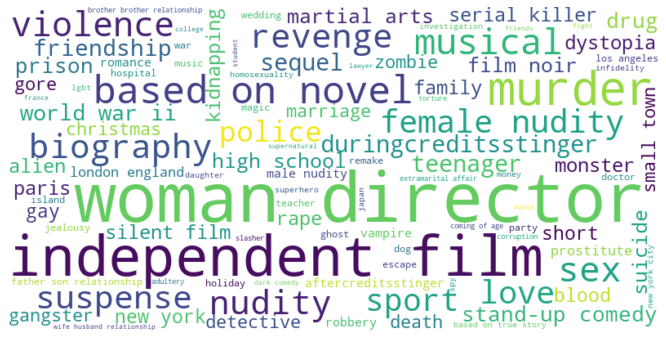

In [42]:
from wordcloud import WordCloud

keywords_freq = movies["keywords"].explode().dropna().value_counts()

wc = WordCloud(background_color="white", max_words=100, width=800, height=400)
wc.generate_from_frequencies(keywords_freq.to_dict())

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

plt.show()

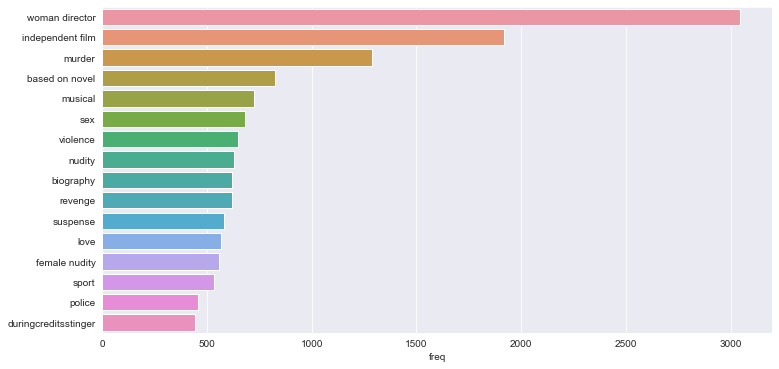

In [43]:
most_freq_keywords = keywords_freq.to_frame("freq").sort_values(by="freq", ascending=False).head(16)

plt.figure(figsize=(12, 6))
sns.barplot(data=most_freq_keywords, x="freq", y=most_freq_keywords.index, orient="h")
plt.show()

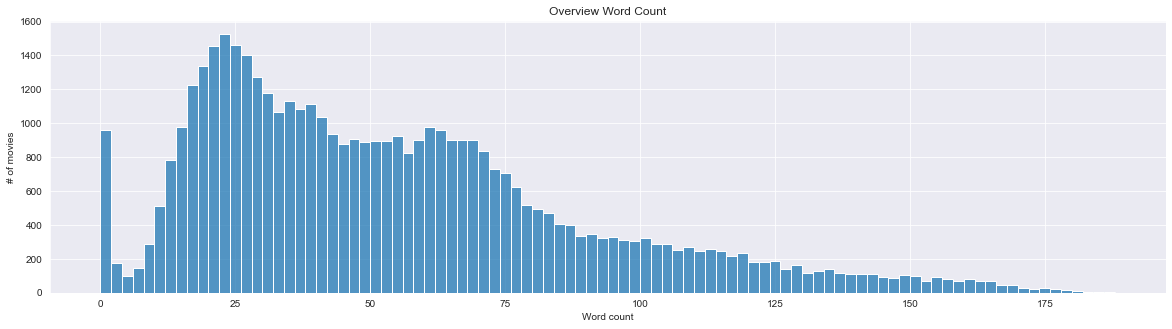

In [44]:
overview_word_count = movies["overview"].fillna("")\
    .apply(lambda overview: 0 if len(overview) == 0 else len(overview.split(" ")))\
    .to_frame()\
    .rename(columns={'overview': 'word_count'})
overview_word_count
plt.figure(figsize=(20, 5))

sns.histplot(data=overview_word_count, x="word_count", binwidth=2)
plt.title("Overview Word Count")
plt.ylabel("# of movies")
plt.xlabel("Word count")

plt.show()

## Finding Correlations

It can be interesting to try and find correlation between some parameters to the movie's vote average.  

Let's start by investigating the genre

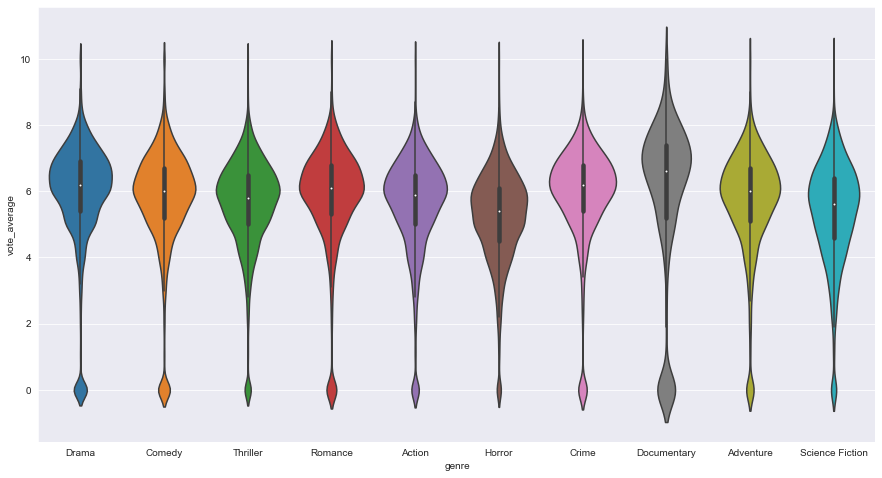

In [45]:
movies_in_top_genres = movies_genres[movies_genres['genre'].isin(top_genres[:10])]
plt.figure(figsize=(15,8))
sns.violinplot(x="genre", y="vote_average", data=movies_in_top_genres, order=top_genres[:10])
plt.show()

We can see that the average rating and its variance is consistent within the top 10 genres, with "Documentary" and "Science Fiction" being the only exception, they are more contreversial in comparsing to the rest of the genres.

# Building a Recommendation System

## Recommendation Systems Types

A recommendation system is a type of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item.  
There are 2 common types of recommendations systems _content based_ and _collaborative based_.

A __content based__ recommendations system uses the description of items and the user's past to recommend items the user might like. Those kind of systems rely on a well tagged dataset of items and the user's preferences

A __collaborative based__ recommendations system doesn't use data on the items at all, rather relying on finding similar interests between different users.  
This is based on the assumption that people who agreed in the past will agree in the future, and that they will like simimlar kinds of items as they liked in the past.The importance of analyzing users' preferences is key, with data collection being collected explicitly (likes, dislikes, ratings) and implicitly (viewing times).

Most recommendations systems feature a hybrid approch of those two methods.

I want to look at the problem from a number of different point of views, so I'll try to create multiple recommendation systems that each function in a different way, and in the end combine all of them.

## First Try - A Content Based Recommendation System

For a content based recommendation system, we need to find similarities between movies based on properties that **we** think are key properties.

We will focus on:
* Genres
* Original language
* Keywords
* Overview
* Crew
    * Director
* Cast
    * Top 5 actors

The properties __genres, original language, keywords, crew and cast__ are unique identifiers, our theory is that movies that contain the same such properties will be a good fit for our users.  
But the __overview__ property is different in that it's a text based description of the movie, so there won't be two movies with the same __overview__, so for the __overview__ propery will take a different approach than the other properties.

### Genres, Original language, Keywords, Director and Top Actors

Let's take a look at these properties, and remove movies that's missing any of these properties:

In [46]:
properties_columns = ["original_language", "genres", "director", "top_actors", "keywords"]
movies[["title", *properties_columns]].head()

,title,original_language,genres,director,top_actors,keywords
0,Toy Story,en,"[Animation, Comedy, Family]",John Lasseter,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva..."
1,Jumanji,en,"[Adventure, Fantasy, Family]",Joe Johnston,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'..."
2,Grumpier Old Men,en,"[Romance, Comedy]",Howard Deutch,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o..."
3,Waiting to Exhale,en,"[Comedy, Drama, Romance]",Forest Whitaker,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin..."
4,Father of the Bride Part II,en,[Comedy],Charles Shyer,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug..."


In [47]:
filtered_movies = movies[movies.apply(lambda row: len(row['keywords']) >= 3 and len(row['top_actors']) >= 1, axis=1)]\
    .dropna(subset=["director"])\
    .fillna({"original_language": ""})

print(f'We can recommend {filtered_movies.shape[0]} movies')

We can recommend 19574 movies


We will use the **Bag of Words** technique to vectorize each movie, which means we need to represent each movie using one sentence.

Columns `keywords` and `top_actors` that cotains lists of strings might have strings with multiple words, for example, the `top_actors` column might contain `["Tom Hanks", "George Kelly", "Tom Holloway"]`, so the final string representing the movie will be `".. Tom Hanks George Kelly Tom Holloway .."`, and so we won't be able to differentiate between Tom Hanks and Tom Holloway, to fix this we'll remove spaces between words in the same string.

In [48]:
def build_plain_properties_corpus(movies_df):
    corpus = []

    for _, m in movies_df.iterrows():
        movie_prop = ""
        for property_column in properties_columns:
            value = m[property_column]
            if isinstance(value, list):
                # We'll remove all inner spaces to differentiate between i.e. "Tom Holloway" and "Tom Hanks"
                no_spaces_value = [item.replace(' ', '') for item in value]
                movie_prop += " ".join(no_spaces_value)
            else:
                movie_prop += value.replace(' ', '')
            movie_prop += " "
        corpus.append(movie_prop)

    return corpus

For example, for the movie "Forrest Gump":

In [49]:
movies[movies['title'] == 'Forrest Gump'][["title", *properties_columns]]

,title,original_language,genres,director,top_actors,keywords
351,Forrest Gump,en,"[Comedy, Drama, Romance]",Robert Zemeckis,"[Tom Hanks, Robin Wright, Gary Sinise, Mykelti...","[vietnam veteran, hippie, mentally disabled, r..."


We'll create the following string that represents it:

```
en Comedy Drama Romance RobertZemeckis TomHanks RobinWright GarySinise MykeltiWilliamson SallyField vietnamveteran hippie mentallydisabled running basedonnovel vietnam vietnamwar friendship love familyrelationships bully mothersonrelationship military hugging shrimping woundedsoldier flashback parkbench amputee
```

**Vectorization Method**

The strings we're dealing with don't have the characteristics of actual documents, they don't have semantic meaning and they don't contain stop words like "the", "and" and so on, these strings are just text representation of the movies' properties, and as such choosing a simple method of feature extraction such as `HashingVectorizer` is fitting.

In [50]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics.pairwise import linear_kernel

class PlainPropertiesRecommender:
    def __init__(self, movies_df):
        self.movies_df = movies_df
        self._corpus = build_plain_properties_corpus(self.movies_df)
        transformer = HashingVectorizer(stop_words="english", ngram_range=(1, 2))
        self._tfidf_matrix = transformer.fit_transform(self._corpus)

    def recommend(self, movie_title: str, top_n: int = 5):
        # We have to reindex the movies DataFrame because later we use indexing into the matrix
        reindexed_movies = self.movies_df.reset_index(drop=True)

        ind = reindexed_movies[reindexed_movies["title"] == movie_title].index.item()

        # Instead of building a matrix of similarities between all movies, we just compare
        # the movie we're interested in with all the movies - this way we don't need too much memory
        sim = linear_kernel(np.asarray(self._tfidf_matrix[ind].todense()), self._tfidf_matrix)

        m_sim = sim[0]
        reindexed_movies["score"] = m_sim

        top_sims = m_sim.argsort()[-1 - top_n:-1]
        top_sims = np.flip(top_sims)

        return reindexed_movies.iloc[top_sims]

plain_props_recommender = PlainPropertiesRecommender(filtered_movies)

Now let's see some results!

In [51]:
display(plain_props_recommender.recommend('Django Unchained')[["id", "title", *properties_columns]])
display(plain_props_recommender.recommend('Avengers: Age of Ultron')[["id", "title", *properties_columns]])
display(plain_props_recommender.recommend('Shutter Island')[["id", "title", *properties_columns]])

,id,title,original_language,genres,director,top_actors,keywords
14638,273248,The Hateful Eight,en,"[Crime, Drama, Mystery, Western]",Quentin Tarantino,"[Samuel L. Jackson, Kurt Russell, Jennifer Jas...","[bounty hunter, wyoming, mountain, narration, ..."
10093,37080,Mother and Child,en,"[Drama, Romance]",Rodrigo García,"[Naomi Watts, Samuel L. Jackson, Annette Benin...","[adoptive mother, nymphomaniac, mother daughte..."
9957,42941,30 Days of Night: Dark Days,en,"[Horror, Thriller]",Ben Ketai,"[Kiele Sanchez, Mia Kirshner, Diora Baird, Rhy...","[hero, vampire, supernatural, revenge, rivalry..."
7725,7874,Black Snake Moan,en,[Drama],Craig Brewer,"[Samuel L. Jackson, Christina Ricci, Justin Ti...","[southern usa, blues, military service, indepe..."
18002,283366,Miss Peregrine's Home for Peculiar Children,en,"[Drama, Fantasy, Adventure]",Tim Burton,"[Eva Green, Asa Butterfield, Samuel L. Jackson...","[time travel, orphan, superpower]"


,id,title,original_language,genres,director,top_actors,keywords
10760,24428,The Avengers,en,"[Science Fiction, Action, Adventure]",Joss Whedon,"[Robert Downey Jr., Chris Evans, Mark Ruffalo,...","[new york, shield, marvel comic, superhero, ba..."
14148,271110,Captain America: Civil War,en,"[Adventure, Action, Science Fiction]",Anthony Russo,"[Chris Evans, Robert Downey Jr., Scarlett Joha...","[civil war, war, marvel comic, sequel, superhe..."
12798,100402,Captain America: The Winter Soldier,en,"[Action, Adventure, Science Fiction]",Anthony Russo,"[Chris Evans, Samuel L. Jackson, Scarlett Joha...","[washington d.c., future, shield, marvel comic..."
14146,284053,Thor: Ragnarok,en,"[Action, Adventure, Fantasy, Science Fiction]",Taika Waititi,"[Chris Hemsworth, Tom Hiddleston, Cate Blanche...","[marvel comic, sequel, superhero, based on com..."
14143,102899,Ant-Man,en,"[Science Fiction, Action, Adventure]",Peyton Reed,"[Paul Rudd, Michael Douglas, Evangeline Lilly,...","[marvel comic, superhero, based on comic, afte..."


,id,title,original_language,genres,director,top_actors,keywords
5601,4176,Murder on the Orient Express,en,"[Drama, Thriller, Mystery]",Sidney Lumet,"[Albert Finney, Lauren Bacall, Martin Balsam, ...","[detective, repayment, orient express, investi..."
9984,1782,Afterwards,en,"[Drama, Thriller, Mystery]",Gilles Bourdos,"[John Malkovich, Romain Duris, Evangeline Lill...","[prophecy, lawyer, doctor]"
5651,9391,Enduring Love,en,"[Drama, Thriller, Mystery]",Roger Michell,"[Daniel Craig, Rhys Ifans, Samantha Morton, Bi...","[picnic, hot air balloon, rescue]"
10848,69668,Dream House,en,"[Drama, Thriller, Mystery]",Jim Sheridan,"[Daniel Craig, Naomi Watts, Rachel Weisz, Mart...","[house fire, extension ladder, last day on job]"
8952,49767,Fade to Black,en,"[Drama, Thriller, Mystery]",Oliver Parker,"[Danny Huston, Diego Luna, Paz Vega, Christoph...","[film making, historical figure, orson welles]"


### Movies' Overview

The __overview__ column contains a short description of the movie plot, and can help us better identify similarities between movies.  

We can't extract features from the __overview__ column the same as we did with the __genres, original language, keywords, crew and cast__ columns, it requires a different approach.  
The problem is that it's a real text, meaning that similar overviews might contain **different words**, but have a **similar meaning**. We will try a number of techniques of finding similar overviews.

The first technique is TF-IDF.

#### TF-IDF

Stands for **term-frequency inverse document-frequency**.  
In this vectorization technique, we treat the __overview__ as a Bag of Words, but instead of just counting the the number of appearences of each word in each document (document here is an __overview__), we also take into account the number of documents the word appears in.  
In general:
* The more a word appears in a document -> the more important it is
* The more documents a word appears in -> the less important it is

For example, for the __overview__ of the movie __Jaws__:
> An insatiable great white shark terrorizes the townspeople of Amity Island, The police chief, an oceanographer and a grizzled shark hunter seek to destroy the bloodthirsty beast.

The word "shark" is less common than "police" in movies' overviews, so it has higher importance.

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

class TfidfRecommender:
    def __init__(self, movies_df):
        self.movies_df = movies_df
        self._corpus = self._build_corpus()
        self._transformer = transformer = TfidfVectorizer(stop_words="english")
        self._tfidf_matrix = transformer.fit_transform(self._corpus)

    def _build_corpus(self):
        return self.movies_df['overview'].fillna("").tolist()

    def recommend(self, movie_title: str, top_n: int = 5):
        # We have to reindex the movies DataFrame because later we use indexing into the matrix
        reindexed_movies = self.movies_df.reset_index(drop=True)

        ind = reindexed_movies[reindexed_movies["title"] == movie_title].index.item()

        # Instead of building a matrix of similarities between all movies, we just compare
        # the movie we're interested in with all the movies - this way we don't need too much memory
        sim = linear_kernel(np.asarray(self._tfidf_matrix[ind].todense()), self._tfidf_matrix)

        m_sim = sim[0]
        reindexed_movies["score"] = m_sim

        top_sims = m_sim.argsort()[-1 - top_n:-1]
        top_sims = np.flip(top_sims)

        return reindexed_movies.iloc[top_sims]

    def compare(self, movie1, movie2):
        # We have to reindex the movies DataFrame because later we use indexing into the matrix
        reindexed_movies = self.movies_df.reset_index(drop=True)

        ind1 = reindexed_movies[reindexed_movies["title"] == movie1].index.item()
        ind2 = reindexed_movies[reindexed_movies["title"] == movie2].index.item()

        sim = linear_kernel(np.asarray(self._tfidf_matrix[ind1].todense()), np.asarray(self._tfidf_matrix[ind2].todense()))

        return sim[0][0]


tfidf_recommender = TfidfRecommender(movies)

In [53]:
with pd.option_context('display.max_colwidth', -1):
    display(tfidf_recommender.recommend('Avengers: Age of Ultron', top_n=5)[["title", "overview", "genres", "keywords"]])
    display(tfidf_recommender.recommend('Shutter Island', top_n=5)[["title", "overview", "genres", "keywords"]])
    display(tfidf_recommender.recommend('Django Unchained', top_n=5)[["title", "overview", "genres", "keywords"]])

,title,overview,genres,keywords
17890,The Avengers,"When an unexpected enemy emerges and threatens global safety and security, Nick Fury, director of the international peacekeeping agency known as S.H.I.E.L.D., finds himself in need of a team to pull the world back from the brink of disaster. Spanning the globe, a daring recruitment effort begins!","[Science Fiction, Action, Adventure]","[new york, shield, marvel comic, superhero, based on comic, alien invasion, superhero team, aftercreditsstinger, duringcreditsstinger, marvel cinematic universe]"
26652,Captain America: Civil War,"Following the events of Age of Ultron, the collective governments of the world pass an act designed to regulate all superhuman activity. This polarizes opinion amongst the Avengers, causing two factions to side with Iron Man or Captain America, which causes an epic battle between former allies.","[Adventure, Action, Science Fiction]","[civil war, war, marvel comic, sequel, superhero, based on comic, imax, aftercreditsstinger, duringcreditsstinger, marvel cinematic universe, 3d]"
15218,Iron Man 2,"With the world now aware of his dual life as the armored superhero Iron Man, billionaire inventor Tony Stark faces pressure from the government, the press and the public to share his technology with the military. Unwilling to let go of his invention, Stark, with Pepper Potts and James 'Rhodey' Rhodes at his side, must forge new alliances – and confront powerful enemies.","[Adventure, Action, Science Fiction]","[malibu, marvel comic, superhero, based on comic, revenge, aftercreditsstinger, marvel cinematic universe]"
30609,A Deadly Adoption,"Things go awry when an author and his wife welcome a pregnant woman into their home, with plans to adopt her baby.","[Drama, Thriller]","[baby, adoption, violence, tv movie, woman director]"
27186,The Day Mars Invaded Earth,Martians replace scientist &amp; his family to pave way for invasion.,[Science Fiction],"[family relationships, martian, outer space, scientist, alien invasion]"


,title,overview,genres,keywords
13770,The Monster,A general store clerk and aspiring detective investigates a mysterious disappearance that took place quite close to an empty insane asylum.,"[Comedy, Horror, Science Fiction]",[silent film]
26452,Stir of Echoes: The Homecoming,A soldier returns home from the Iraq war only to be haunted by visions of the dead.,"[Horror, Thriller]",[]
17500,Education for Death,A propaganda film during World War II about a boy who grows up to become a Nazi soldier.,[Animation],"[world war ii, wartime, war propaganda, disney short, short]"
20103,Asylum Blackout,A group of cooks at an asylum for the criminally insane get locked in with the inmates during a massive thunderstorm,"[Horror, Thriller]",[]
21582,Act of Love,An American soldier romances a beautiful Parisian during the final days of World War II.,"[Drama, War, Romance]","[suicide, melodrama, prostitution]"


,title,overview,genres,keywords
18539,One for the Money,"An unemployed lingerie buyer convinces her bail bondsman cousin to give her a shot as a bounty hunter. Her first assignment is to track down a former cop on the run for murder – the same man who broke her heart years before. With the help of some friends and the best bounty hunter in the business, she slowly learns what it takes to be a true bounty hunter.","[Action, Comedy, Crime]","[bounty hunter, based on novel, romance, framed, bail jumper, woman director]"
37259,Band of Angels,"Living in Kentucky prior to the Civil War, Amantha Starr is a privileged young woman. Her widower father, a wealthy plantation owner, dotes on her and he sends her to the best schools. When he dies suddenly however, Amantha's world is turned upside down. She learns that her father had been living on borrowed money and that her mother was actually a slave and her father's mistress. The plantation is to be sold to pay off her father's debts and as the daughter of slave, Amatha is also to be sold as property. She is bought by a Louisiana plantation owner, Hamish Bond and over time she grows to love him until she learns he was a slave-trader. She tries again to become part of white society but realizes that her future lies elsewhere.","[Adventure, Romance, Drama, History]","[plantation, slave, southern belle]"
28417,Bare Knuckles,A bounty hunter in Los Angeles sets out to track down and stop a masked serial killer who murders women by using kung-fu moves.,"[Adventure, Action, Thriller]",[]
32655,Moving Target,A bounty hunter with a pregnant wife who is urging him to get a regular job gets framed for murder and trapped in a war between Russian gangsters.,[],[]
7962,The Tin Star,An experienced bounty hunter helps a young sheriff learn the meaning of his badge.,"[Action, Drama, Western, Romance]","[mixed race child, seamstress, hanging posse, two guns belt]"


**Analyzing the Results**

Let's dig deeper into the results we got for "Django Unchained", this is its overview:
> With the help of a German bounty hunter, a freed slave sets out to rescue his wife from a brutal Mississippi plantation owner.

The overviews of the movies "One for the Money", "Bare Knuckles", "Moving Target" and "The Tin Star" are similar to the overview of Django Unchained's in the words __bounty, hunter__, this is good, but are we missing other movies that are also similar to "Django Unchained"?  

To demonstrate the problem, let's consider "12 Years a Slave"'s overview:
> In the pre-Civil War United States, Solomon Northup, a free black man from upstate New York, is abducted and sold into slavery. Facing cruelty as well as unexpected kindnesses Solomon struggles not only to stay alive, but to retain his dignity. In the twelfth year of his unforgettable odyssey, Solomon’s chance meeting with a Canadian abolitionist will forever alter his life.

In this overview we see quite a few words that relate to "Django Unchained"'s overview - __black man, slavery__, these words do not appear in "Django Unchained"'s overview, but are semantically strongly related.

Let's compare "Django Unchained" with "12 Years a Slave" and TF-IDF's top recommendation - "One for the Money":

In [54]:
import gensim

with pd.option_context('display.max_colwidth', -1):
    display(movies[movies["title"].isin(["Django Unchained", "12 Years a Slave", "One for the Money"])][["title", "overview", "genres"]])

movies_comparison = movies[movies["title"].isin(["Django Unchained", "12 Years a Slave", "One for the Money"])][["title", "overview"]]
movies_words = {
    row['title']: set(gensim.utils.simple_preprocess(row['overview'])) for _, row in movies_comparison.iterrows()
}
f_i_inter = movies_words['Django Unchained'].intersection(movies_words['12 Years a Slave'])
f_m_inter = movies_words['Django Unchained'].intersection(movies_words['One for the Money'])

print(f"There's {len(f_i_inter)} words in common between Django Unchained and 12 Years a Slave: {f_i_inter}")
print(f"There's {len(f_m_inter)} words in common between Django Unchained and One for the Money: {f_m_inter}")

print()
print("TF-IDF Recommender Similarity Score:")
print(f'Django Unchained <> 12 Years a Slave {tfidf_recommender.compare("Django Unchained", "12 Years a Slave")}')
print(f'Django Unchained <> One for the Money {tfidf_recommender.compare("Django Unchained", "One for the Money")}')

,title,overview,genres
18539,One for the Money,"An unemployed lingerie buyer convinces her bail bondsman cousin to give her a shot as a bounty hunter. Her first assignment is to track down a former cop on the run for murder – the same man who broke her heart years before. With the help of some friends and the best bounty hunter in the business, she slowly learns what it takes to be a true bounty hunter.","[Action, Comedy, Crime]"
20128,Django Unchained,"With the help of a German bounty hunter, a freed slave sets out to rescue his wife from a brutal Mississippi plantation owner.","[Drama, Western]"
21950,12 Years a Slave,"In the pre-Civil War United States, Solomon Northup, a free black man from upstate New York, is abducted and sold into slavery. Facing cruelty as well as unexpected kindnesses Solomon struggles not only to stay alive, but to retain his dignity. In the twelfth year of his unforgettable odyssey, Solomon’s chance meeting with a Canadian abolitionist will forever alter his life.","[Drama, History]"


There's 6 words in common between Django Unchained and 12 Years a Slave: {'of', 'his', 'from', 'the', 'with', 'to'}
There's 7 words in common between Django Unchained and One for the Money: {'help', 'of', 'hunter', 'the', 'with', 'to', 'bounty'}

TF-IDF Recommender Similarity Score:
Django Unchained <> 12 Years a Slave 0.0
Django Unchained <> One for the Money 0.305188247165715


Here we can see the root of the problem - "One for the Money" has more words in common with "Django Unchained" compared to "12 Years a Slave" and its similarity score is much higher, with "12 Years a Slave" and "Django Unchained" having a similarity score of 0!  
Our model doesn't take into account semantically close words like __black man and slavery__ and __slavery__.

#### Doc2Vec

TF-IDF is a good technique, but it's naive, it only compares words by equality and doesn't know anymore than that. We want a model that can compare words not just in a binary way, for example to know that "slave" and "slavery" or "slave" and "black" are close in meaning, even if they aren't exactly the same word.

In 2013 a technique named Word2Vec [was published](https://arxiv.org/pdf/1301.3781.pdf), allowing to create a model that can find synonymous words and indicate **semantic similarity** between words.  
The model converts words into vectors such that the consine similarity between those vectors indicate that semantic similarity, we can use that property to compare words in a more meaningful way.

We are interested in an algorithm named Doc2Vec [published in 2014](https://cs.stanford.edu/~quocle/paragraph_vector.pdf) which should work better for documents over simple Word2Vec techniques.  
We will be using the [Gensim](https://radimrehurek.com/gensim/index.html) library to train a model for our specific corpus of documents.

In [55]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [56]:
import os
import gensim

class Doc2VecRecommender:
    def __init__(self, movies_df):
        self.movies_df = movies_df
        self._corpus = list(self._build_corpus())
        self._model = self._train_model()

    def _build_corpus(self):
        # The corpus is just the tokenized overviews
        for index, row in self.movies_df[~self.movies_df["overview"].isna()].iterrows():
            tokens = gensim.parsing.preprocessing.preprocess_string(row['overview'])
            yield gensim.models.doc2vec.TaggedDocument(tokens, [str(index)])

    def _train_model(self):
        if os.path.exists(".cache/overviews.model"):
            return gensim.models.doc2vec.Doc2Vec.load(".cache/overviews.model")
        
        model = gensim.models.doc2vec.Doc2Vec(vector_size=100, window=6, min_count=4, epochs=40, workers=4, dbow_words=1)
        model.build_vocab(self._corpus)
        model.train(self._corpus, total_examples=model.corpus_count, epochs=model.epochs)
        os.makedirs(".cache", exist_ok=True)
        model.save(".cache/overviews.model")
        return model

    def recommend(self, movie_title: str, top_n: int = 5):
        overview = self.movies_df[self.movies_df['title'] == movie_title].iloc[0]['overview']
        overview_toks = gensim.parsing.preprocessing.preprocess_string(overview)

        overview_vec = self._model.infer_vector(overview_toks)
        similarities = self._model.dv.most_similar([overview_vec], topn=top_n)
        indices = [int(tag) for tag, _ in similarities]
        scores = [similarity_score for _, similarity_score in similarities]

        results = self.movies_df.loc[indices]
        results["score"] = scores
        return results

    def compare(self, movie1, movie2):
        overview1 = self.movies_df[self.movies_df['title'] == movie1].iloc[0]['overview']
        overview2 = self.movies_df[self.movies_df['title'] == movie2].iloc[0]['overview']

        overview1_toks = gensim.utils.simple_preprocess(overview1)
        overview2_toks = gensim.utils.simple_preprocess(overview2)

        overview1_vec = d2v_recommender._model.infer_vector(overview1_toks)
        overview2_vec = d2v_recommender._model.infer_vector(overview2_toks)

        return self._model.dv.cosine_similarities(overview1_vec, [overview2_vec]).item()

d2v_recommender = Doc2VecRecommender(movies)

2022-07-19 09:22:07,503 : INFO : loading Doc2Vec object from .cache/overviews.model
2022-07-19 09:22:07,529 : INFO : loading dv recursively from .cache/overviews.model.dv.* with mmap=None
2022-07-19 09:22:07,529 : INFO : loading wv recursively from .cache/overviews.model.wv.* with mmap=None
2022-07-19 09:22:07,530 : INFO : setting ignored attribute cum_table to None
2022-07-19 09:22:07,688 : INFO : Doc2Vec lifecycle event {'fname': '.cache/overviews.model', 'datetime': '2022-07-19T09:22:07.688468', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


In [57]:
with pd.option_context('display.max_colwidth', -1):
    display(d2v_recommender.recommend('Django Unchained', 10)[["id", "title", "overview", "score"]])

,id,title,overview,score
20128,68718,Django Unchained,"With the help of a German bounty hunter, a freed slave sets out to rescue his wife from a brutal Mississippi plantation owner.",0.931856
4523,20006,Pink Cadillac,Clint Eastwood plays a bounty hunter who helps out the wife of a bail-jumper after her child is kidnapped by neo-Nazi types.,0.675412
29110,91628,Three Quarter Moon,"Hartmut Mackowiak, a German taxi driver, tries to help 6 year old Turkish girl to find her mother.",0.651500
45057,3178,Beat,The story of writer William Seward Burroughs and his wife.,0.612526
34379,159365,Benaam,"After helping a stabbing victim to the hospital, a man begins to receive anonymous threats. The only way to save his wife and child is to unravel the mystery of the killer's identity.",0.609116
42483,373514,Night Chase,A man fleeing the scene of his wife's shooting forms an unexpected relationship with the tough cab driver he hires to drive him to the Mexican border.,0.592261
9191,55257,Juha,"A farmer's wife is seduced into running away from her stolid older husband by a city slicker, who enslaves her in a brothel.",0.589852
27030,37484,I Love Trouble,A wealthy man hires a detective to investigate his wife's mysterious past.,0.588826
38369,123182,Coastlines,"An ex-con returns to his Florida hometown after three years and becomes involved with the wife of his best friend, the local sheriff.",0.587749
26800,183247,The Inspector,"At the end of WW2, a compassionate Dutch policeman helps smuggle a Jewish woman into British Palestine.",0.587385


**Analyzing the Results**

Let's look at common topics between "Django Unchained" and the recommended movies:
* "Pink Cadillac" - common topics are __bounty hunting, helping wives and Germans (mentioned as "Nazis" in "Pink Cadillac")__
* "Three Quarter Moon" - common topics are __German people, help__
* "Beat" - common topics are __wife__
* "Benaam" - common topics are __wife__
* "Night Chase" - common topics are __wife, slave__

The results aren't very good, and I think there's still much to be desired.

Let's look at our previous example - "Django Unchained", "12 Years a Slave" and "One for the Money":

In [58]:
print(f'Django Unchained <> 12 Years a Slave - {d2v_recommender.compare("Django Unchained", "12 Years a Slave")}')
print(f'Django Unchained <> One for the Money - {d2v_recommender.compare("Django Unchained", "One for the Money")}')

Django Unchained <> 12 Years a Slave - 0.17589826881885529
Django Unchained <> One for the Money - 0.34603333473205566


Here we can see that our model ranks "12 Years a Slave" closer to "Django Unchained" than our TF-IDF recommender, this is good progress.

#### Word2Vec

A potential problem in our previous model Doc2Vec might be the lack of training data. We only trained it on our corpus of movie overviews, and this might not be enough for the model to learn semantic similarity of many words.  
Next we will use a pre-trained model published by Google and trained on Google News dataset of about 100 billion words. The dataset contains 300-dimensional vectors of 3 million words.

In [59]:
import gensim
import gensim.downloader as api
from gensim.models.keyedvectors import KeyedVectors

google_news_wv: KeyedVectors = api.load('word2vec-google-news-300')

2022-07-19 09:22:08,710 : INFO : loading projection weights from /Users/adi/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
2022-07-19 09:22:47,749 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from /Users/adi/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2022-07-19T09:22:47.749748', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  5 2022, 01:53:17) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'load_word2vec_format'}


In [60]:
import random

random.choices(google_news_wv.index_to_key, k=10)

['Psychedelic_Studies_MAPS',
 'Citation_Handicap',
 'Widescreen_LCD_Monitor',
 'medicine_dropper',
 'Vung_Ro',
 'Jim_Gabarra',
 'ASIAN_ADRS',
 '7lb_8oz',
 'Shiv_Sena_Supremo_Bal',
 'MDRSP']

Unlike Doc2Vec which we trained on documents, the pre-trained Google News model contains a vector per word, and isn't familiar with our movies corpus, a naive approach to solve this problem was suggested by [Mike Tamir](https://www.youtube.com/watch?v=7gTjYwiaJiU), to average the word vectors. For example all words in the book "A Tale of Two Cities" should add up to "class-struggle".

Because all those vectors that represent words live in a space where the distance between them correspond to semantic distance, we can manipulate those vectors by averaging them, and the resulting vector represent the general "direction" of the document, and each word in the document contributed to that direction.

![Word vectors average](resources/naivedoc2vec.png)

In [61]:
from nltk.corpus import stopwords

def tokenize_movie_overview(overview: str):
    return [word for word in gensim.utils.tokenize(overview) if word not in stopwords.words('english')]

def get_text_mean_vector(overview: str):
    tokens = tokenize_movie_overview(overview)
    
    word_vectors = np.empty((0, 300), np.float32)
    for token in tokens:
        try:
            word_vectors = np.append(word_vectors, np.array([google_news_wv[token]]), axis=0)
        except KeyError:
            # We don't have this word in the google-news model
            pass

    # If we weren't able to vectorize any words - return NaN
    if word_vectors.shape[0] == 0:
        return np.nan
        
    return np.mean(word_vectors, axis=0)

In [62]:
from sklearn.metrics.pairwise import cosine_similarity

overview = movies[movies["title"] == "Django Unchained"].iloc[0]["overview"]
print(overview)

print()
mean_vector = get_text_mean_vector(overview)
print("Most similar words to Django Unchained's overview")
for index, (key, score) in enumerate(google_news_wv.similar_by_vector(mean_vector, 3)):
    print(f"{index + 1}. {key} - {score}")

print()
for word in ['slave', 'black', 'banana', 'car']:
    other_word_vec = google_news_wv[word]
    print(f"The average vector and [{word}] similarity score: {cosine_similarity([mean_vector], [other_word_vec])[0][0]}")

With the help of a German bounty hunter, a freed slave sets out to rescue his wife from a brutal Mississippi plantation owner.

Most similar words to Django Unchained's overview
1. desicritic_editor_slave - 0.6243675351142883
2. slave - 0.5932321548461914
3. Deposed_Mauritanian_president - 0.5579289793968201

The average vector and [slave] similarity score: 0.5932321548461914
The average vector and [black] similarity score: 0.31050509214401245
The average vector and [banana] similarity score: 0.2602415084838867
The average vector and [car] similarity score: 0.23750826716423035


"Django Unchained"'s overview is closer semantically to the word "slave" than it is to "banana".

We can now turn this concept into a recommender

In [63]:
cache = None

In [64]:
import os
import gensim

class Word2VecRecommender:
    def __init__(self, movies_df):
        self.movies_df = movies_df.copy()
        self._generate_w2v()
        self._model = google_news_wv

    def _generate_w2v(self):
        global cache
        if cache is None:
            cache = self.movies_df["overview"].apply(lambda overview: get_text_mean_vector(overview) if isinstance(overview, str) else np.nan)
        
        self.movies_df['w2v'] = cache

    def recommend(self, movie_title: str, top_n: int = 5):
        target_w2v = self.movies_df[self.movies_df['title'] == movie_title].iloc[0]['w2v']
        others_w2v = self.movies_df[~self.movies_df["w2v"].isna()]

        similarities = cosine_similarity([target_w2v], others_w2v['w2v'].to_list())[0]
        others_w2v["score"] = similarities
        return others_w2v.iloc[similarities.argsort()[-top_n - 1:][::-1]]

    def compare(self, movie1, movie2):
        movie1_w2v = self.movies_df[self.movies_df['title'] == movie1].iloc[0]['w2v']
        movie2_w2v = self.movies_df[self.movies_df['title'] == movie2].iloc[0]['w2v']

        return self._model.cosine_similarities(movie1_w2v, [movie2_w2v]).item()

w2v_recommender = Word2VecRecommender(movies)

In [65]:
with pd.option_context('display.max_colwidth', -1):
    display(w2v_recommender.recommend('Django Unchained')[["title", "overview"]])

/var/folders/tl/9n338bsj4217gjszrx8gmpg80000gn/T/ipykernel_75105/1997904561.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  others_w2v["score"] = similarities


,title,overview
20128,Django Unchained,"With the help of a German bounty hunter, a freed slave sets out to rescue his wife from a brutal Mississippi plantation owner."
37259,Band of Angels,"Living in Kentucky prior to the Civil War, Amantha Starr is a privileged young woman. Her widower father, a wealthy plantation owner, dotes on her and he sends her to the best schools. When he dies suddenly however, Amantha's world is turned upside down. She learns that her father had been living on borrowed money and that her mother was actually a slave and her father's mistress. The plantation is to be sold to pay off her father's debts and as the daughter of slave, Amatha is also to be sold as property. She is bought by a Louisiana plantation owner, Hamish Bond and over time she grows to love him until she learns he was a slave-trader. She tries again to become part of white society but realizes that her future lies elsewhere."
18539,One for the Money,"An unemployed lingerie buyer convinces her bail bondsman cousin to give her a shot as a bounty hunter. Her first assignment is to track down a former cop on the run for murder – the same man who broke her heart years before. With the help of some friends and the best bounty hunter in the business, she slowly learns what it takes to be a true bounty hunter."
38274,Free State of Jones,"In 1863, Mississippi farmer Newt Knight serves as a medic for the Confederate Army. Opposed to slavery, Knight would rather help the wounded than fight the Union. After his nephew dies in battle, Newt returns home to Jones County to safeguard his family but is soon branded an outlaw deserter. Forced to flee, he finds refuge with a group of runaway slaves hiding out in the swamps. Forging an alliance with the slaves and other farmers, Knight leads a rebellion that would forever change history."
30382,Freedom,"Two men separated by 100 years are united in their search for freedom. In 1856 a slave, Samuel Woodward and his family, escape from the Monroe Plantation near Richmond, Virginia. A secret network of ordinary people known as the Underground Railroad guide the family on their journey north to Canada. They are relentlessly pursued by the notorious slave hunter Plimpton. Hunted like a dog and haunted by the unthinkable suffering he and his forbears have endured, Samuel is forced to decide between revenge or freedom. 100 years earlier in 1748, John Newton the Captain of a slave trader sails from Africa with a cargo of slaves, bound for America. On board is Samuel's great grandfather whose survival is tied to the fate of Captain Newton. The voyage changes Newton's life forever and he creates a legacy that will inspire Samuel and the lives of millions for generations to come."
4335,Adanggaman,"In West Africa during the late 17th century, King Adanggaman leads a war against his neighboring tribes, ordering his soldiers to torch enemy villages, kill the elderly and capture the healthy tribesmen to sell to the European slave traders. When his village falls prey to one of Adanggaman's attacks, Ossei manages to escape, but his family is murdered except for his captured mother. Chasing after the soldiers in an effort to free her, Ossei is befriended by a fierce warrior named Naka."


**Analyzing the Results**

The movies "Free State of Jones" and "Freedom" have __slaves, war and family__ topics in common with "Django Unchained", while "The Muthers" have __helping and plantations__.  

What about our previous example of comparing between "Django Unchained", "12 Years a Slave" and "One for the Money"?

In [66]:
print(f'Django Unchained <> 12 Years a Slave - {w2v_recommender.compare("Django Unchained", "12 Years a Slave")}')
print(f'Django Unchained <> One for the Money - {w2v_recommender.compare("Django Unchained", "One for the Money")}')

Django Unchained <> 12 Years a Slave - 0.6098563075065613
Django Unchained <> One for the Money - 0.7272599935531616


This time, we see that the pre-trained Google News Word2Vec model managed to get "12 Years a Slave" even closer to "Django Unchained" than our TF-IDF or Doc2Vec recommenders, which indicated it's an improvement regarding semantic comparisons.

Previously we explained that we can average a document into a single vector which can be represented by the closest word, let's try to visualize this in the case of our movies recommendations and see if we can cluster movies by "summary words".

First, we'll choose the top movies by vote count and add a column for the Word2Vec _overview_ mean vector

In [115]:
movies_to_plot = movies.sort_values(by='vote_count', ascending=False).head(50)
movies_to_plot["w2v"] = movies_to_plot['overview'].apply(get_text_mean_vector)

Next we'll cluster our movies according to their Word2Vec mean vector

In [116]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10)
centers_labels = kmeans.fit_predict(movies_to_plot["w2v"].to_list())

centers = kmeans.cluster_centers_

And build our dictionary of possible summary words our of all the words in the movies' overviews:

In [117]:
all_keywords = set()
for overview in movies_to_plot["overview"]:
    tokens = tokenize_movie_overview(overview)
    all_keywords.update(tokens)

all_keywords = list(all_keywords)

all_keywords_with_vecs = {
    keyword: google_news_wv[keyword] for keyword in all_keywords if keyword in google_news_wv
}

In [118]:
center_words = []

for center in centers:
    sims = cosine_similarity([center], list(all_keywords_with_vecs.values()))[0]
    center_words.append(list(all_keywords_with_vecs.keys())[sims.argsort()[-1]])

movies_to_plot["summary_word"] = [center_words[label] for label in centers_labels]

In [119]:
import plotly.io as pio

# This is so NBViewer will render our plotly figures correctly.
pio.renderers.default = "notebook_connected"

In [120]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(2)

m_2d_vec = pca.fit_transform(movies_to_plot["w2v"].to_list())
movies_to_plot["w2v_x"] = m_2d_vec[:,0]
movies_to_plot["w2v_y"] = m_2d_vec[:,1]

fig = px.scatter(movies_to_plot, x="w2v_x", y="w2v_y", color="summary_word", hover_name="title", hover_data=["genres"], width=1000)
fig.show()

In [121]:
with pd.option_context('display.max_colwidth', -1):
    display(movies_to_plot[["title", "summary_word"]].groupby("summary_word")["title"].apply(lambda x: ', '.join(x)).reset_index())

,summary_word,title
0,Frodo,"The Hobbit: An Unexpected Journey, The Lord of the Rings: The Return of the King, The Lord of the Rings: The Two Towers"
1,Jurassic,Jurassic World
2,abducted,Guardians of the Galaxy
3,alien,"Avatar, The Martian, WALL·E"
4,evil,"The Dark Knight, The Dark Knight Rises, The Matrix, Iron Man, Star Wars: The Force Awakens, Skyfall, Batman Begins, Captain America: The First Avenger, Star Wars, The Wolf of Wall Street, Inglourious Basterds, Shutter Island, The Revenant"
5,interstellar,Interstellar
6,learns,"Harry Potter and the Philosopher's Stone, Man of Steel"
7,prison,"Django Unchained, The Shawshank Redemption, Suicide Squad"
8,really,"Inception, The Avengers, Fight Club, The Hunger Games, Mad Max: Fury Road, Iron Man 3, The Lord of the Rings: The Fellowship of the Ring, Pulp Fiction, Forrest Gump, Titanic, Pirates of the Caribbean: The Curse of the Black Pearl, Up, Inside Out, The Amazing Spider-Man, The Hunger Games: Catching Fire, Despicable Me, The Hangover"
9,superhero,"Deadpool, Captain America: Civil War, Batman v Superman: Dawn of Justice, Iron Man 2, Avengers: Age of Ultron, Thor"


The results are very interesting! The summary words are quite good and the clustering makes sense! Lord of the Rings movies, alien movies, and so on.

Word2Vec is a very impressive model!

### Combining the Models

We have 1 model for the columns __genre, original language, keywords, director and top actors__ - based on the `HashingVectorizer` and 3 models for the __overview__ column - based on `TF-IDF`, `Doc2Vec` and a pre-trained `Word2Vec` on Google News.

We'll combine the `PlainPropertiesRecommender` and the `Word2VecRecommender` by averaging the similarity scores of the results.

In [67]:
import os
import gensim

class ContentBasedRecommender:
    def __init__(self, recommender_1, weight_1, recommender_2, weight_2):
        self.recommender_1 = recommender_1
        self.weight_1 = weight_1
        self.recommender_2 = recommender_2
        self.weight_2 = weight_2

    def recommend(self, movie_title: str, top_n: int = 5):
        recommendations1 = self.recommender_1.recommend(movie_title, movies.shape[0])
        recommendations1['score'] = recommendations1['score'] * self.weight_1
        recommendations2 = self.recommender_2.recommend(movie_title, movies.shape[0])
        recommendations2['score'] = recommendations2['score'] * self.weight_2

        combined = recommendations1.merge(recommendations2[["id", "score"]], on='id')

        combined['mean_score'] = (combined['score_x'].to_numpy() + combined['score_y'].to_numpy()) / 2

        return combined.sort_values(by='mean_score', ascending=False).head(top_n)

In [68]:
content_recommender = ContentBasedRecommender(plain_props_recommender, 0.7, w2v_recommender, 0.3)
with pd.option_context('display.max_colwidth', -1):
    display(content_recommender.recommend('Django Unchained', 10)[['title', 'overview', 'score_x', 'score_y', 'mean_score']])

/var/folders/tl/9n338bsj4217gjszrx8gmpg80000gn/T/ipykernel_75105/1997904561.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  others_w2v["score"] = similarities


,title,overview,score_x,score_y,mean_score
7,Hannie Caulder,Hannie enlists the aid of bounty hunter Tom Price to teach her how to be a gunfighter so she can hunt down the 3 men who killed her husband and raped her.,0.100401,0.207007,0.153704
0,The Hateful Eight,Bounty hunters seek shelter from a raging blizzard and get caught up in a plot of betrayal and deception.,0.129165,0.166284,0.147724
9,Kite,"Based on the groundbreaking, cult classic anime, KITE tells the story of Sawa, a young woman living in a corrupt society where crime and gangs terrorize the streets. When Sawa's mother and policeman father are found victims of a grisly double homicide, she begins a ruthless pursuit for the man who murdered them. With the help of her father's ex-partner, Karl Aker, and a mysterious friend from her past, she becomes a merciless teen assassin, blasting her way through the dark world of human trafficking only to uncover a devastating truth",0.099859,0.179401,0.139630
184,The Muthers,A band of female pirates go undercover at a prison camp on a coffee plantation to rescue their leader's sister.,0.068994,0.209818,0.139406
40,Ride with the Devil,"Ride with the Devil follows four people who are fighting for truth and justice amidst the turmoil of the American Civil War. Director Ang Lee takes us to a no man's land on the Missouri/Kansas border where a staunch loyalist, an immigrant's son, a freed slave, and a young widow form an unlikely friendship as they learn how to survive in an uncertain time. In a place without rules and redefine the meaning of bravery and honor.",0.083215,0.194907,0.139061
6,The Outlaw Josey Wales,"After avenging his family's brutal murder, Wales is pursued by a pack of soldiers. He prefers to travel alone, but ragtag outcasts are drawn to him - and Wales can't bring himself to leave them unprotected.",0.103141,0.172448,0.137795
26,Return to Lonesome Dove,"'Captain' Call has just buried Gus at Lonesome Dove and plans to head back to his ranch in Montana. Looking at a herd of wild Mustangs, he decides to drive them north with the help of Isom and Gideon Walker. Gideon hires Agostina Vega and Mexican Cowboys to run the Mustangs. Call leaves the drive for Nebraska and runs into Cherokee Jack and a group of Indians, which almost costs him his life. In Montana, Newt and Jasper get into a shoot out in the local bar and wind up in jail. The odds of them surviving the lynch mob are slim until Dunnegan has them freed. However, Newt and Jasper will have to work for Dunnegan to keep their freedom. Newt has mixed emotions about working for Dunnegan who helps him in any way, because he also has respect for Call - who may or may not be his true father. Dunnegan has big plans for his cattle and the future. Those plans do not include those who do not throw in with him and the Hat Creek Cattle Company is not interested in Dunnegan.",0.089626,0.185428,0.137527
535,Freedom,"Two men separated by 100 years are united in their search for freedom. In 1856 a slave, Samuel Woodward and his family, escape from the Monroe Plantation near Richmond, Virginia. A secret network of ordinary people known as the Underground Railroad guide the family on their journey north to Canada. They are relentlessly pursued by the notorious slave hunter Plimpton. Hunted like a dog and haunted by the unthinkable suffering he and his forbears have endured, Samuel is forced to decide between revenge or freedom. 100 years earlier in 1748, John Newton the Captain of a slave trader sails from Africa with a cargo of slaves, bound for America. On board is Samuel's great grandfather whose survival is tied to the fate of Captain Newton. The voyage changes Newton's life forever and he creates a legacy that will inspire Samuel and the lives of millions for generations to come.",0.058674,0.215860,0.137267
28,Tom Horn,A renowned former army scout is hired by ranchers to hunt down rustlers but finds himself on trial for the murder of a boy when he carries out his job too well.

## Second Try - A Collaborative Based Recommendation System

This time we will completely ignore the movies' properties and focus solely on finding similarities between different users.  
This technique is known as **collaborative filtering**, and the idea behind it is to find recommendations for movies through similarity between users who rated them, as an example, let's say that we have 5 users and 5 movies:

![1](https://github.com/adi-benz/movies-rating-analysis/raw/main/resources/cf-1.png)

and for each (user, movie) we have a rating of thumbs up or thumbs down, and when trying to know if we want to recommend the _blue movie_ to _user 5_

![2](https://github.com/adi-benz/movies-rating-analysis/raw/main/resources/cf-2.png)

we can look at _user 2_ and _user 3_ which also like movies similar to _user 5_ and also watched the _blue movie_, so we in this case we can see that _user 5_ and _user 3 & 4_ have similar taste and so it's likely that _user 5_ will **not like** the _blue movie_.

The important thing is that all this can be done **without any knowledge about the movies themselves**.

This technique has some key **advantages** over content based systems:
1. The recommendation scope isn't limited - if we have a user that only like racing movies we would only recommend movies with similar plot, meaning movie about racing, but with collaborative filtering we might find that users that usually like racing movies also like war movies, and through the recommendation system expose the user to new content he might like
2. It isn't domain specific - we don't have to get familiar with the different properties of movies, we let the similarity between users to do the work

And **disadvantages**:
1. The requirement for a big dataset of users' interactions
2. The variety of the recommendations will be as good as the users'

### Singular Value Decomposition (SVD)

A well established way of performing collaborative recommendations is by using SVD.  
As always we want to represent our movies as vectors so we can manipulate them easily, and while in a content based recommendation system we did that by extract features as we saw fit like genre, overview, director and so on, with collaborative systems we generate features for the movies by using the users' ratings.  
These features are called **latent features**, meaning hidden features, these features are auto generated, not selected by a data scientist and are unrelated to the actual movie itself, they are derived from the ratings alone.

This technique of using SVD for collaborative recommender systems is so common that there's a library named [surpr!se](http://surpriselib.com/) that is dedicated for this purpose. And that will be what I will use.

For the purpose of training our model we will use our `ratings.csv` dataset that contains 26 million ratings from 260,000 users for 45,000 movies.

In [72]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

class SvdRecommender:
    def __init__(self, movies_df, ratings):
        self.movies_df = movies_df.copy()
        self.ratings = ratings
        self.model = self._train_model()

    def _train_model(self):
        reader = Reader(rating_scale=(1, 5))

        # surprise's dataset receives the DataFrame in the order [user ID, movie ID, rating]
        data = Dataset.load_from_df(self.ratings[["userId", "movieId", "rating"]], reader)

        train_set, test_set = train_test_split(data, test_size=0.25)

        model = SVD(n_factors=20)
        model.fit(train_set)

        test_predictions = model.test(test_set)
        accuracy.rmse(test_predictions)

        return model

    def recommend(self, movie_title: str, top_n: int = 5):
        target_movie = self.movies_df[self.movies_df["title"] == movie_title].iloc[0]
        target_movie_vec = self.model.qi[self.model.trainset.to_inner_iid(target_movie["id"])]

        similarities_score = cosine_similarity([target_movie_vec], self.model.qi)[0]

        indices = similarities_score.argsort()[-top_n - 1:-1][::-1]
        scores = np.sort(similarities_score)[-top_n - 1:-1][::-1]

        movie_ids = [self.model.trainset.to_raw_iid(i) for i in indices]

        movies_recomms = self.movies_df.set_index('id').loc[movie_ids]
        movies_recomms['score'] = scores
        return movies_recomms

    def compare(self, movie1, movie2):
        movie1_id = self.movies_df[self.movies_df["title"] == movie1].iloc[0]["id"]
        movie2_id = self.movies_df[self.movies_df["title"] == movie2].iloc[0]["id"]

        movie1_item_id = self.model.trainset.to_inner_iid(movie1_id)
        movie2_item_id = self.model.trainset.to_inner_iid(movie2_id)

        score = cosine_similarity([self.model.qi[movie1_item_id]], [self.model.qi[movie2_item_id]])[0]

        return score

svd_recommender = SvdRecommender(movies, ratings)

In [73]:
with pd.option_context('display.max_colwidth', 100):
    display(svd_recommender.recommend("Django Unchained", 10)[["title", "overview", "score"]])
    display(svd_recommender.recommend("Shutter Island", 10)[["title", "overview", "score"]])

,title,overview,score
id,,,
16869,Inglourious Basterds,"In Nazi-occupied France during World War II, a group of Jewish-American soldiers known as ""The B...",0.929231
273248,The Hateful Eight,Bounty hunters seek shelter from a raging blizzard and get caught up in a plot of betrayal and d...,0.906308
22311,The Inglorious Bastards,"Set in Europe during WWII, a group of American soldiers on their way to military prison are bese...",0.851407
106646,The Wolf of Wall Street,A New York stockbroker refuses to cooperate in a large securities fraud case involving corruptio...,0.839610
1422,The Departed,"To take down South Boston's Irish Mafia, the police send in one of their own to infiltrate the u...",0.815120
1124,The Prestige,A mysterious story of two magicians whose intense rivalry leads them on a life-long battle for s...,0.811372
550,Fight Club,A ticking-time-bomb insomniac and a slippery soap salesman channel primal male aggression into a...,0.802091
807,Se7en,Two homicide detectives are on a desperate hunt for a serial killer whose crimes are based on th...,0.790385
281957,The Revenant,"In the 1820s, a frontiersman, Hugh Glass, sets out on a path of vengeance against those who left...",0.769244


,title,overview,score
id,,,
1124,The Prestige,A mysterious story of two magicians whose intense rivalry leads them on a life-long battle for s...,0.847816
68718,Django Unchained,"With the help of a German bounty hunter, a freed slave sets out to rescue his wife from a brutal...",0.768647
1830,Lord of War,"Yuri Orlov is a globetrotting arms dealer and, through some of the deadliest war zones, he strug...",0.766525
31011,Mr. Nobody,"Nemo Nobody leads an ordinary existence with his wife and 3 children; one day, he wakes up as a ...",0.761079
9533,Red Dragon,"Former FBI Agent Will Graham, who was once almost killed by the savage Hannibal 'The Cannibal' L...",0.752916
4553,The Machinist,"The Machinist is the story of Trevor Reznik, a lathe-operator who is dying of insomnia. In a mac...",0.750031
4922,The Curious Case of Benjamin Button,"Tells the story of Benjamin Button, a man who starts aging backwards with bizarre consequences.",0.744877
1427,Perfume: The Story of a Murderer,"Jean-Baptiste Grenouille, born in the stench of 18th century Paris, develops a superior olfactor...",0.736266
37954,The Breaking Point,Based on the Hemingway novel To Have and Have Not. A fisherman with money problems hires out his...,0.731174


From looking at the result we can appriciate how good the recommender is, with so little effort!

**Analyzing the Results**

We got an RMSE of ~0.80, for comparison we can calculate the RMSE of the most trivial predictor - always guessing the mean rating

In [76]:
mean_score = ratings["rating"].mean()
print(f"The mean score of the {ratings.shape[0]} ratings is {mean_score:.4f}")

rmse_of_trivial = np.sqrt(((ratings["rating"].to_numpy() - mean_score) ** 2).mean())
print(f"RMSE of trivial mean score prediction is {rmse_of_trivial:.4f}")

The mean score of the 26010786 ratings is 3.5280
RMSE of trivial mean score prediction is 1.0653


Our SVD recommender is a 24.9% improvement over the trivial one, this is quite good for an off-the-shelf model.

The really interesting part is the **how** these results were achived.  
For a deeper dive, let's create an interactive plot of the top 500 rated movies and try to spot interesting trends.

In [78]:
movies_to_plot = movies.sort_values(by='vote_count', ascending=False).head(500)

For each movie, we'll need its vector of features created by our SVD model

In [79]:
def get_svd_model_vec(movie_id: int):
    inner_item_id = svd_recommender.model.trainset.to_inner_iid(movie_id)
    return svd_recommender.model.qi[inner_item_id]

movies_to_plot["vec"] = movies_to_plot['id'].apply(get_svd_model_vec)

To be able to plot these vectors, we need to perform dimention reduction, we'll use PCA for that

In [80]:
from sklearn.decomposition import PCA

pca = PCA(2)
    
m_2d_vec = pca.fit_transform(movies_to_plot["vec"].to_list())
movies_to_plot["vec_x"] = m_2d_vec[:,0]
movies_to_plot["vec_y"] = m_2d_vec[:,1]

Finally, let's plot the vectors and try to find some clusters

In [82]:
from sklearn.cluster import KMeans
import plotly.express as px

kmeans = KMeans(n_clusters=30)
labels = kmeans.fit_predict(movies_to_plot["vec"].to_list())
movies_to_plot["label"] = labels

fig = px.scatter(movies_to_plot, x="vec_x", y="vec_y", color="label", hover_name="title", hover_data=["genres"], width=1000)
fig.show()

The clusters are very interesting since we can clearly see they group movies by topics, for example _action_, _horror_, _animation_, and more

In [83]:
for label in range(10):
    print(movies_to_plot[movies_to_plot["label"] == label].head(5)["title"].to_list())

['Beauty and the Beast', 'Finding Dory', 'The Fate of the Furious', "Miss Peregrine's Home for Peculiar Children", 'Get Out']
['The Godfather', 'The Silence of the Lambs', 'The Shining', 'Blade Runner', 'A Clockwork Orange']
['Interstellar', 'Shutter Island', 'The Revenant', 'Gone Girl', 'Life of Pi']
['The Great Gatsby', 'The Fault in Our Stars', 'The Secret Life of Pets', 'Hacksaw Ridge', 'The Secret Life of Walter Mitty']
["Harry Potter and the Philosopher's Stone", 'Harry Potter and the Deathly Hallows: Part 2', 'Harry Potter and the Prisoner of Azkaban', 'Harry Potter and the Chamber of Secrets', 'Harry Potter and the Goblet of Fire']
['Suicide Squad', 'Batman v Superman: Dawn of Justice', 'Man of Steel', 'X-Men: Apocalypse', 'The Amazing Spider-Man 2']
['Star Wars: The Force Awakens', 'Star Wars', 'The Empire Strikes Back', 'Return of the Jedi']
['Twilight', 'Fifty Shades of Grey', 'The Twilight Saga: Breaking Dawn - Part 2', 'The Twilight Saga: Breaking Dawn - Part 1', 'The Twil

# Further Plans For The Final Project

I think that with more tweaking to the content based model I can get better results, I think that the "keywords" column doesn't give indication for the similarities between movies, and because of the duplication with "crew" and "cast" there's not enough emphasis on the plot.

It would be very interesting to compare the different results of the models and try to analyse the reasons each model behaved the way it did.

Using only my judgment as a way to determine how well a recommender performs is really not good enouhg, I want to dive deeper into different ways to determine how successful a recommendations system is.

# Closing Thoughts

Points:
* Need more data for content based - maybe longer descriptions of the plot or review
* collaborative fixed the issue of discoverability
* Content based takes a lot of time and tuning, needs to discover different features
* Learned a lot, didn't have prior knowledge or experience